# Project pipeline

This notebook contains the full pipeline from **data curation** to **transfer learning**. 

It has been optimized to work on a RTX3070 with **8GB VRAM**. 

Make sure to create a venv using the **requirements.txt**


## Contents

* **Dataset:**  
  Download the Animals-10 dataset from kaggle and save to data. 

* **Analysis:**  
  Initial analysis for necessary statistics for ResNet50 model training. 

* **Outlier detection:**  
  Create embedding vectors from images and use a combination of PCA and UMAP to display and detect outliers. 

* **Webdataset:**  
  Create a portable WebDataset including training and test shards. 

* **Hyperparameter tuning:**  
  Utilize ML Flow and Optuna to track, store and optimize a hyperparameter space. 

* **Final model:**  
  Trains a final model using the best hyperparameters and compare it to the test set. 

## Data Curation
Dataset, Analysis, Outlier detection, Webdataset

### Imports

In [ ]:
#from tqdm.auto import tqdm

### Dataset

Dataset used is Animals-10 from Kaggle. 

It contains about 27k images obtained by webscraping Google image search for 10 different animals. 

In [1]:
# Download dataset from Kaggle
import kagglehub
from functions.data_curation import prepare_animal_dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")

# Prepare the dataset with translated class names
dataset_stats = prepare_animal_dataset(
    path, 
    destination_dir = './data/raw', 
    verbose = False
    )


Summary: 10 folders copied successfully
No errors occurred

Contents of destination directory:
  - butterfly: 2112 files
  - sheep: 1820 files
  - dog: 4863 files
  - cat: 1668 files
  - chicken: 3098 files
  - spider: 4821 files
  - squirrel: 1862 files
  - cow: 1866 files
  - elephant: 1446 files
  - horse: 2623 files


### Initial analysis and cleanup
Display relevant statistics and create a cleaned copy of the dataset.

Provides **dataset_analysis_report.txt** & **dataset_cleaning_report.txt** for reference.

## 📂 Dataset Folder Structure

```
DATASET_PATH: ./data/raw/
FOLDER_STRUCTURE:
  - sheep (1820 images)
  - butterfly (2112 images)
  - chicken (3098 images)
  - elephant (1446 images)
  - cat (1668 images)
  - horse (2623 images)
  - squirrel (1862 images)
  - cow (1866 images)
  - spider (4821 images)
  - dog (4863 images)

```

## 📊 Dataset Summary Statistics

,Total Classes,Total Images,Avg Images/Class,Unique Formats,Corrupted Files
0,10,26179,2617.900000,3,0


## 🔍 Small Image Analysis

,Threshold,Count,% of Total
0,< 224px,11956,45.7%
1,< 128px,125,0.5%
2,< 64px,5,0.0%
3,< 32px,0,0.0%


## 📁 Class Distribution

,Class,Count,% Total
9,dog,4863,18.600000
8,spider,4821,18.400000
2,chicken,3098,11.800000
5,horse,2623,10.000000
1,butterfly,2112,8.100000
7,cow,1866,7.100000
6,squirrel,1862,7.100000
0,sheep,1820,7.000000
4,cat,1668,6.400000
3,elephant,1446,5.500000


## 🖼️ Image Characteristics

,Width,Height
Metric,,
Average,320.000000,252.600000
Minimum,60.000000,57.000000
Maximum,6720.000000,6000.000000


,Value
Metric,
Average,1.310000
Median,1.330000
Minimum,0.290000
Maximum,4.230000
Std Dev,0.310000


,Category,Count,% of Total
0,Square (0.9-1.1),3029,11.6%
1,Portrait (<0.9),3129,12.0%
2,Landscape (>1.1),20021,76.5%


,Channel Type,Count
0,RGB,26128
1,RGBA,50
2,Grayscale,1


## 📄 File Formats

,Extensions
0,.jpeg
1,.jpg
2,.png


## ❌ Corrupted Files

✅ No corrupted files found

## 📸 Sample Images

Report saved to dataset_analysis_report.txt


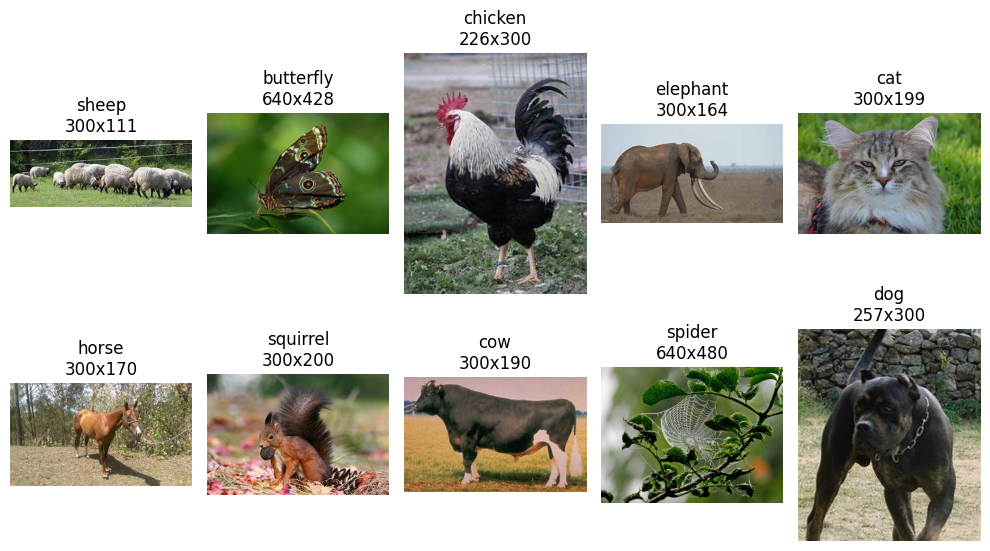

In [2]:
# Analysis and report
from functions.data_curation import analyze_dataset, display_dataset_report
analysis = analyze_dataset(dataset_path="./data/raw/")
display_dataset_report(analysis)

In [3]:
# Clean dataset
from functions.data_curation import clean_image_dataset
clean_stats = clean_image_dataset(
    src_path="./data/raw/",
    dest_path="./data/cleaned/",
    keep_grayscale=False,
    keep_rgba=False,
    keep_duplicates=False,
    min_resolution=128,
    use_analysis=analysis
)

=== Dataset Cleaning Complete ===

Source: ./data/raw/
Destination: ./data/cleaned/

Total files processed: 26179
Total files copied: 26003
Total files excluded: 176

Detailed report saved to dataset_cleaning_report.txt


### Outlier analysis

Utilize headless ResNet50 to create embedding vectors of each image. 

Applies a combination of PCA and UMAP to display dataset clusters as well as a configurable outlier map.

#### Config

In [4]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = "data/cleaned"
UMAP_PARAMS = {
    'n_components': 2,
    'target_metric': 'categorical',
    'target_weight': 0.5,
    'random_state': 42,
    'n_jobs': -1
}

#### Process data

##### Get pre-trained embeddings from resnet50

In [5]:
from functions.data_curation import (
    initialize_model, 
    process_image_directory, 
    create_embeddings
    )
model, transform = initialize_model(DEVICE)
features, labels, paths = process_image_directory(DATA_PATH, DEVICE, transform)
embedding, le, pca, reducer = create_embeddings(features, labels, umap_params=UMAP_PARAMS)

##### Outlier settings

Configurable settings.  
Apply and check samples.  
Make a decision on how much data you are willing to cut in order to skip manual inspection. 

In [6]:
from functions.data_curation import (
    detect_outliers, 
    create_results_dataframe
    )
# Detect outliers
class_outliers, global_outliers = detect_outliers(
    embedding, labels,
    class_n_neighbors=30,
    class_contamination=0.05,
    global_n_neighbors=75,
    global_contamination=0.05
)
df = create_results_dataframe(embedding, labels, paths, class_outliers, global_outliers)

#### Visualization

##### Plots

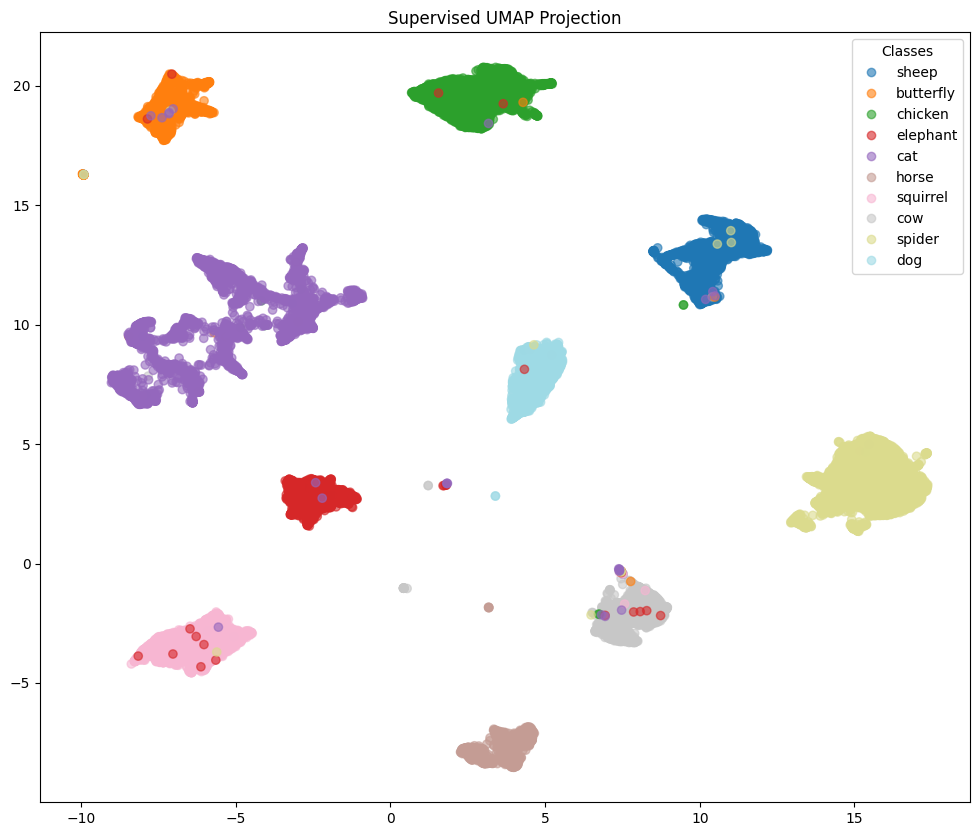

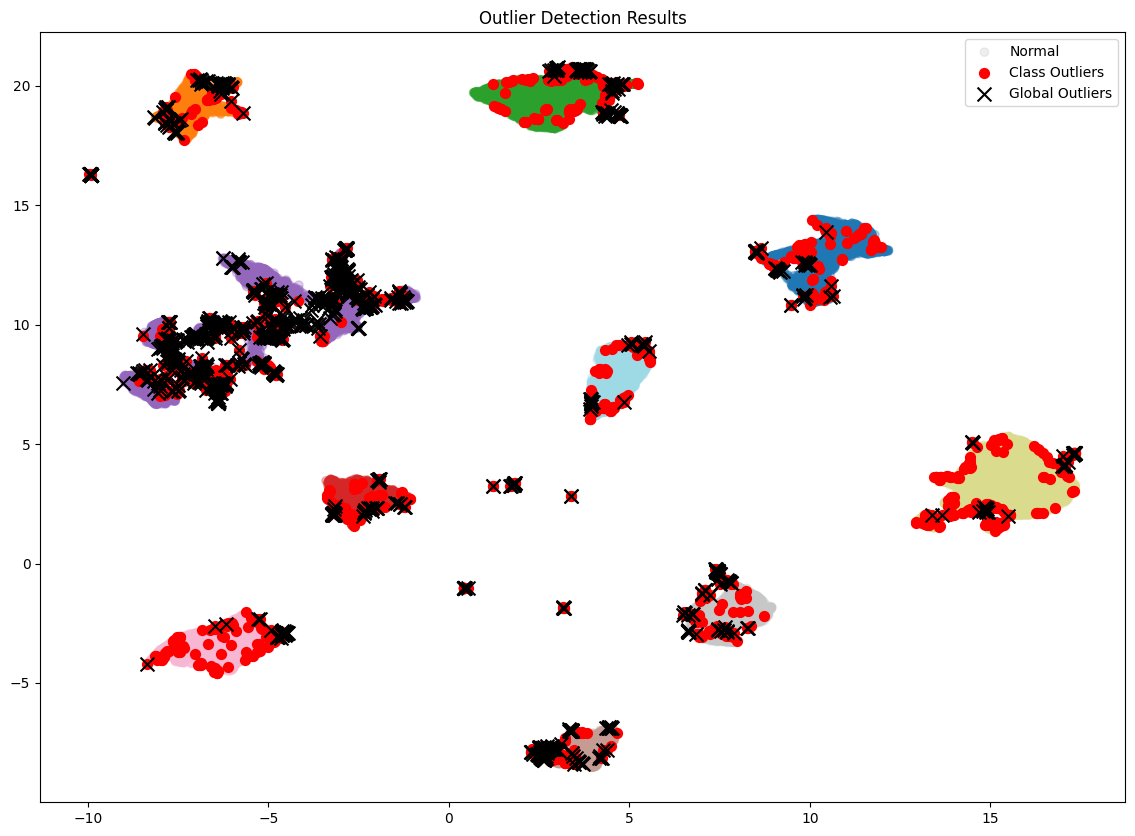

In [7]:
from functions.data_curation import (
    plot_umap, 
    plot_outliers
    )
plot_umap(df)
plot_outliers(df)

##### Statistics

In [8]:
from functions.data_curation import display_outlier_stats
# Display outlier statistics
display_outlier_stats(df)

,Total,Class_Outliers,Global_Outliers,Class_%,Global_%
label,,,,,
dog,4849,243,670,5.000000,13.800000
spider,4806,241,46,5.000000,1.000000
chicken,3082,155,94,5.000000,3.000000
horse,2610,131,45,5.000000,1.700000
butterfly,2065,104,50,5.000000,2.400000
squirrel,1857,93,31,5.000000,1.700000
cow,1848,93,66,5.000000,3.600000
sheep,1800,90,55,5.000000,3.100000
cat,1653,83,112,5.000000,6.800000


##### Sample outliers

Change RANDOM_STATE to scroll through samples of detected outliers. 

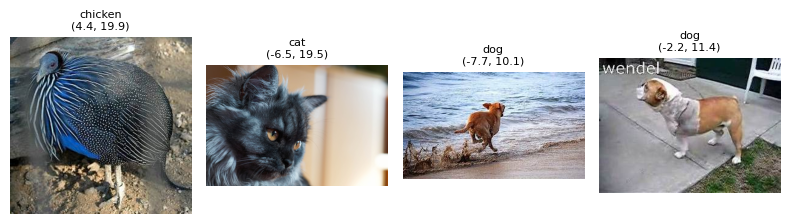

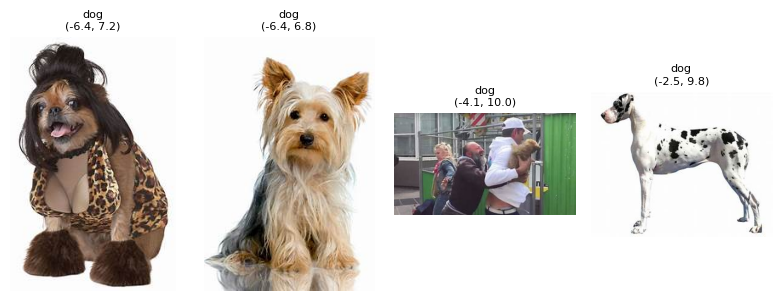

In [40]:
from functions.data_curation import display_outlier_samples
# Display outlier samples
RANDOM_STATE = 765765
N_SAMPLES = 4
FIGSIZE = (8, 3)
display_outlier_samples(df, outlier_type='class', random_state=RANDOM_STATE, n_samples=N_SAMPLES, figsize=FIGSIZE)
display_outlier_samples(df, outlier_type='global', random_state=RANDOM_STATE, n_samples=N_SAMPLES, figsize=FIGSIZE)

##### Save non-outliers in a seperate folder

In [41]:
from functions.data_curation import create_clean_dataset
clean_data_root = "data/no_outliers"  # Where to save cleaned dataset

# Run the cleaning process
create_clean_dataset(df, clean_data_root)

Copying clean images: 100%|██████████| 23864/23864 [00:03<00:00, 7299.28it/s]


Done! Clean dataset created at data/no_outliers
Original images: 26003
Clean images: 23864
Outliers removed: 2139

Class distribution in clean dataset:
butterfly: 1938 images
cat: 1485 images
chicken: 2862 images
cow: 1719 images
dog: 4126 images
elephant: 1262 images
horse: 2447 images
sheep: 1699 images
spider: 4565 images
squirrel: 1761 images


### Curated WebDataset

Use center crop.  
Resize to 224 by 224 pixels.  
Save as training & test shards.  
The test set will be balanced.

#### Process data

In [42]:
# Set random seed for reproducibility
import random
import numpy as np
random.seed(42)
np.random.seed(42)

In [43]:
from functions.data_curation import process_dataset
# Set paths
input_dir = "./data/no_outliers/"
output_dir = "./data/webdataset/"

# Process parameters
test_size = 0.2         # 20% of the smallest class for balanced testing
samples_per_shard = 1000  # Number of samples per WebDataset shard

# Execute processing
results = process_dataset(
    input_dir=input_dir,
    output_dir=output_dir,
    test_size=test_size,
    samples_per_shard=samples_per_shard
)

Found 10 classes with 23864 total images
Created balanced test set with 2520 images (252 per class)
Training set has 21344 images

Class distribution in train set:
butterfly: 1686
cat: 1233
chicken: 2610
cow: 1467
dog: 3874
elephant: 1010
horse: 2195
sheep: 1447
spider: 4313
squirrel: 1509

Class distribution in test set:
butterfly: 252
cat: 252
chicken: 252
cow: 252
dog: 252
elephant: 252
horse: 252
sheep: 252
spider: 252
squirrel: 252
Writing 21344 samples to 21 shards at ./data/webdataset/train-%06d.tar


Creating train dataset: 100%|████████████| 21344/21344 [00:44<00:00, 482.79it/s]


Finished writing train dataset
Writing 2520 samples to 2 shards at ./data/webdataset/test-%06d.tar


Creating test dataset: 100%|███████████████| 2520/2520 [00:05<00:00, 469.85it/s]

Finished writing test dataset


#### Verification

Checking path: ./data/webdataset/
Directory exists. Files in directory:
  train-000000.tar
  train-000001.tar
  train-000002.tar
  train-000003.tar
  train-000004.tar
  train-000005.tar
  train-000006.tar
  train-000007.tar
  train-000008.tar
  train-000009.tar
  train-000010.tar
  train-000011.tar
  train-000012.tar
  train-000013.tar
  train-000014.tar
  train-000015.tar
  train-000016.tar
  train-000017.tar
  train-000018.tar
  train-000019.tar
  train-000020.tar
  train-000021.tar
Using the first WebDataset file: ./data/webdataset/train-000000.tar
Verifying WebDataset at ./data/webdataset/train-000000.tar...


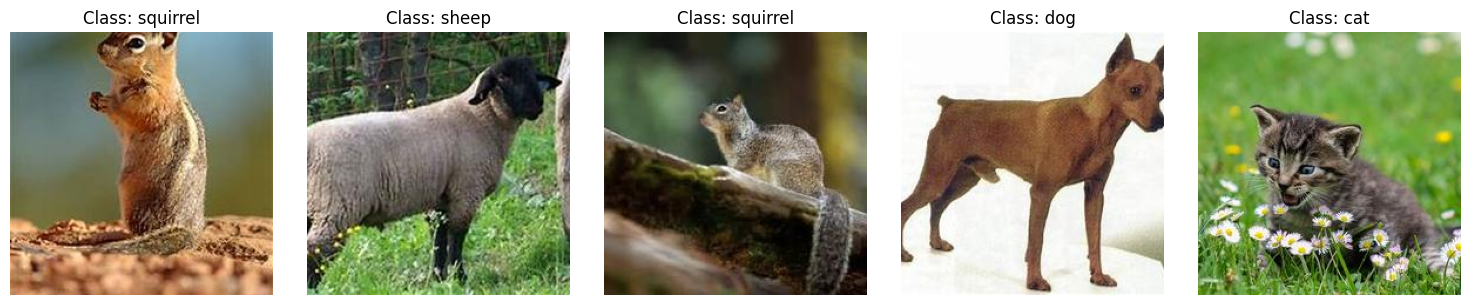

WebDataset verification successful!


In [ ]:
import os
from functions.data_curation import verify_webdataset
output_dir = "./data/webdataset/"

# Verify the training dataset
# Make sure the path exists
print(f"Checking path: {output_dir}")
if os.path.exists(output_dir):
    print(f"Directory exists. Files in directory:")
    train_files = []
    for f in sorted(os.listdir(output_dir)):
        if f.startswith('train-'):
            train_files.append(f)
            print(f"  {f}")
    
    if not train_files:
        print("No training files found!")
    else:
        # Use just the first file for testing to simplify
        train_path = os.path.join(output_dir, train_files[0])
        print(f"Using the first WebDataset file: {train_path}")
        verify_webdataset(train_path)
else:
    print(f"Directory does not exist!")

## Hyperparameter tuning

### Setup

In [1]:
import torch
# Check for GPU availability and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print GPU info if available
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # Convert to GB
    print(f"GPU: {gpu_name} with {gpu_mem:.2f} GB memory")
    
    # Additional GPU optimization for RTX 3070 (8GB VRAM)
    torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes
    print("CUDNN benchmark enabled for performance optimization")

Using device: cuda:0
GPU: NVIDIA GeForce RTX 3070 with 8.00 GB memory
CUDNN benchmark enabled for performance optimization


In [2]:
import config
import mlflow
import glob
import os
from model_creation import analyze_webdataset
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="webdataset")

# Configure MLflow
mlflow.set_experiment("animals10")

# Define constants
DATA_DIR = "./data/webdataset/"

# Relative file paths
config.TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "train-*.tar")))
config.TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "test-*.tar")))
# Absolute paths
# config.TRAIN_PATHS = sorted([os.path.abspath(path) for path in glob.glob(os.path.join(DATA_DIR, "train-*.tar"))])
# config.TEST_PATHS = sorted([os.path.abspath(path) for path in glob.glob(os.path.join(DATA_DIR, "test-*.tar"))])


print(f"Found {len(config.TRAIN_PATHS)} training files and {len(config.TEST_PATHS)} test files")

num_classes, class_names, class_weights = analyze_webdataset(DATA_DIR, verbose=False)
print(f"\nTraining data summary:")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Class weights tensor shape: {class_weights.shape}")

# Update the config module variables
config.NUM_CLASSES = num_classes
config.CLASS_NAMES = class_names
config.CLASS_WEIGHTS = class_weights


Found 22 training files and 3 test files

Training data summary:
Number of classes: 10
Class names: ['spider', 'dog', 'chicken', 'horse', 'butterfly', 'squirrel', 'cow', 'sheep', 'cat', 'elephant']
Class weights tensor shape: torch.Size([10])


### Hyperparameter search
3 fold cross validation was used. 

Aggressive pruning by first fold minimum threshold as well as optunas median pruning strategy by running validation accuracy average after each fold. 

Metric used in optuna optimization is the lower bound of the average validation accuracy from the collective best epoch of all folds measured with the t-distribution at 80% confidence. 

Each trial is stored using ML Flow and can be viewed by typing mlflow ui in the terminal. 

Hyperparameter study from optuna uses SQLite and stored in the root project folder using db_path variable.

In [3]:
# Run the k-fold cross validation optimization
from model_creation import run_kfold_optuna_optimization
db_path = "optuna_animals10_kfold.db"
k_fold_study = run_kfold_optuna_optimization(
    n_trials=20,      # Number of trials
    k=3,             # Number of folds
    verbose=True,   # Reduce output
    storage=db_path, # Store results in SQLite
    load_if_exists=True,
    first_fold_min_acc=95.0  # Minimum accuracy for the first fold
)

Using SQLite storage at: sqlite:///optuna_animals10_kfold.db


[I 2025-05-04 23:42:28,837] Using an existing study with name 'animals10_kfold' instead of creating a new one.


Loaded existing study with 4 previous trials.
Could not load existing study: Record does not exist.
GPU memory: Allocated: 0.00 GB, Reserved: 0.00 GB
Analyzing class distributions in 0 shards...
Created 3 folds with the following statistics:
Fold 1: 0 shards, 0 samples
Fold 2: 0 shards, 0 samples
Fold 3: 0 shards, 0 samples


[W 2025-05-04 23:42:29,106] Trial 4 failed with parameters: {'learning_rate': 0.0001329291894316216, 'batch_size': 8, 'weight_decay': 2.9380279387035354e-06, 'dropout_rate': 0.07799726016810132, 'augmentation_intensity': 'medium', 'patience': 8, 'max_epochs': 10} because of the following error: IndexError('list index out of range').
Traceback (most recent call last):
  File "/home/eaglewing/repo/ml/image-recognition-pipeline/venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/eaglewing/repo/ml/image-recognition-pipeline/model_creation.py", line 1095, in objective_wrapper
    return objective_kfold(trial, k=k, verbose=verbose, first_fold_min_acc=first_fold_min_acc)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eaglewing/repo/ml/image-recognition-pipeline/model_creation.py", line 776, in objective_kfold
    wds.


--- Fold 1/3 ---
Training on 0 shards, validating on 0 shards
Error during optimization: list index out of range


In [ ]:
# To get detailed analysis of your hyperparameter optimization:
enhanced_optuna_analysis(k_fold_study)

In [ ]:
# To visualize metrics for the best trial:
visualize_best_trial_metrics(k_fold_study)

In [ ]:
def display_model_visualizations(run_id=None, experiment_name="animals10"):
    """
    Find and display visualization artifacts (confusion matrix, correct and 
    incorrect classifications) from the best MLflow run.
    
    Args:
        run_id (str, optional): Specific MLflow run ID to use. If None, uses the best run.
        experiment_name (str): Name of the MLflow experiment to search.
    
    Returns:
        dict: Dictionary with paths to downloaded artifacts
    """
    import mlflow
    from mlflow.tracking import MlflowClient
    import matplotlib.pyplot as plt
    from PIL import Image
    import os
    
    # Create MLflow client
    client = MlflowClient()
    
    # Find experiment
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"Experiment '{experiment_name}' not found.")
        return None
    
    # Get the run
    if run_id is None:
        # Find all runs in the experiment
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        if len(runs) == 0:
            print(f"No runs found in experiment '{experiment_name}'.")
            return None
            
        # Try to find final_model runs with test accuracy
        final_model_runs = runs[runs["tags.mlflow.runName"].str.contains("final_model", na=False)]
        
        if len(final_model_runs) > 0 and "metrics.test_acc" in final_model_runs.columns:
            # Use the final model run with highest test accuracy
            best_run = final_model_runs.sort_values("metrics.test_acc", ascending=False).iloc[0]
            run_id = best_run.run_id
            test_acc = best_run["metrics.test_acc"]
            print(f"Using final model run {run_id} with test accuracy: {test_acc:.2f}%")
        elif "metrics.test_acc" in runs.columns:
            # Fall back to any run with test accuracy
            best_run = runs.sort_values("metrics.test_acc", ascending=False).iloc[0]
            run_id = best_run.run_id
            test_acc = best_run["metrics.test_acc"]
            print(f"Using run {run_id} with test accuracy: {test_acc:.2f}%")
        else:
            # Just take the most recent run
            run_id = runs.iloc[0].run_id
            print(f"Using most recent run: {run_id}")
    
    print(f"Searching for visualization artifacts in run: {run_id}")
    
    # Define the artifacts we're looking for
    target_artifacts = [
        "confusion_matrix.png",
        "correct_classifications.png",
        "incorrect_classifications.png"
    ]
    
    # Recursive function to search for artifacts in nested directories
    def find_artifact_paths(client, run_id, artifact_names, path=""):
        found_paths = {}
        artifacts = client.list_artifacts(run_id, path)
        
        for artifact in artifacts:
            full_path = os.path.join(path, artifact.path) if path else artifact.path
            
            if artifact.is_dir:
                # Search recursively in subdirectories
                nested_paths = find_artifact_paths(client, run_id, artifact_names, full_path)
                found_paths.update(nested_paths)
            elif os.path.basename(full_path) in artifact_names:
                found_paths[os.path.basename(full_path)] = full_path
        
        return found_paths
    
    # Find all matching artifacts
    artifact_paths = find_artifact_paths(client, run_id, target_artifacts)
    
    if not artifact_paths:
        print("\nNo visualization artifacts found in this run.")
        print("Available artifacts:")
        for a in client.list_artifacts(run_id):
            print(f"- {a.path}")
        return {}
    
    # Dictionary to store downloaded artifacts
    downloaded_artifacts = {}
    
    # Download and display each artifact if available
    for target in target_artifacts:
        if target in artifact_paths:
            artifact_path = artifact_paths[target]
            
            # Download the artifact
            local_path = client.download_artifacts(run_id, artifact_path)
            downloaded_artifacts[target] = local_path
            
            # Create a nice title
            title = target.replace('.png', '').replace('_', ' ').title()
            print(f"\n## {title}")
            
            try:
                # Load and display the image
                img = Image.open(local_path)
                plt.figure(figsize=(14, 12))
                plt.imshow(img)
                plt.axis('off')
                plt.title(title, fontsize=14)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error displaying {target}: {e}")
        else:
            print(f"\n## {target.replace('.png', '').replace('_', ' ').title()}")
            print(f"Artifact '{target}' not found in run {run_id}")
    
    return downloaded_artifacts

### Train final model

In [ ]:
# Train the final model after hyperparameter optimization
final_model, final_test_acc = train_final_model(k_fold_study)
print(f"Final model test accuracy: {final_test_acc:.2f}%")

In [ ]:
# Display visualizations from the best run
artifacts = display_model_visualizations()